In [1]:
using DrWatson

@quickactivate "FissionYeast"

projectname()

"FissionYeast"

In [2]:
using Distributions
using CairoMakie
using Random
using Distributed
using Optimization
using OptimizationOptimJL
using LinearAlgebra
using DataFrames
using XLSX
using Statistics
using Base.Iterators
using LogExpFunctions
using KernelDensity
using HighestDensityRegions
using LogDensityProblems
using ForwardDiff
using AdaptiveMCMC
using TransformVariables, TransformedLogDensities, LogDensityProblems, LogDensityProblemsAD,
    DynamicHMC, DynamicHMC.Diagnostics

import ForwardDiff: hessian

using OptimizationNLopt

using ColorSchemes, Colors
using Dates

include(srcdir("FissionYeast.jl"));

In [3]:
save_figs = false  # save figures
run_evolution = false # run agent-based evolutionary simulations
save_data_outputs = false # save simulation output datafiles

false

In [4]:
posterior_data = load(datadir("exp_pro/PQInference/posterior_hill_Final.jld2"))

posterior = posterior_data["all_posterior"]

p_map_orig =  posterior_data["map"]

kp = posterior_data["ratio"]

# p_map = (f = 0.9, hm = p_map_orig[:hm], am = p_map_orig[:am], κm = p_map_orig[:κm], Δm = p_map_orig[:Δm], hq = p_map_orig[:hq], aq = p_map_orig[:aq], κq = p_map_orig[:κq], Δq = p_map_orig[:Δq])

3.60141956626879

In [5]:
expData = load(datadir("exp_pro/PQInference/ExpDataFinal_Final.jld2"))

PmData = expData["PmData"];
QData = expData["QData"];

cap = ceil(QData[end,:AU])

15.0

In [12]:
reproductive_fitness(rm,rp,p) = 2*(1-p[:f])*(q(rm,p) +  q(rp,p)) + 4*p[:f]*Pm(rm,rp,p)

reproductive_fitness(r,p) = reproductive_fitness(r[1],r[2],p)

reproductive_fitness_sym(r,p) = reproductive_fitness(r,r,p)

####################

reproductive_fitness_opt(r,p) = -reproductive_fitness(r,p)
reproductive_fitness_opt_1d(r,p) = -reproductive_fitness_sym(r[1],p)

####################

optf = OptimizationFunction(reproductive_fitness_opt, Optimization.AutoForwardDiff())

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, typeof(reproductive_fitness_opt), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED_NO_TIME), Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing}) (generic function with 1 method)

In [7]:
σ = 0.025
additive_mutation_distribution = Normal(0.,σ)

max_au_correspondence = cap

max_pop_size = 10000

n_mitosis_rounds = 1

p_sister = 0.

PP = PopulationParameters(max_pop_size,Int(max_pop_size/2),n_mitosis_rounds,p_sister,additive_mutation_distribution,max_au_correspondence);

In [8]:
N_gen = 20000
initial_spore = Spore(1.,1.)

Spore(1.0, 1.0)

In [14]:
n_grid = 200

function evaluate_r(prob,p)
    prob = remake(prob, p = p)

    sol = solve(prob,Opt(:LD_LBFGS, 2))
    
    return (sol.u[1],sol.u[2])
end

prob = OptimizationProblem(optf, [0.001*cap,0.999*cap], p_map_orig,lb = [0.,0.], ub = [cap,cap])

aq_range = LinRange(1, cap, n_grid)
am_range = LinRange(1, cap, n_grid)

z_as_05 = [evaluate_r(prob,(f = 0.6, hm = 2., am = am, κm = 1., Δm = 1., hq = 2., aq = aq, κq = 1., Δq = 1.)) for aq in aq_range, am in am_range];
z_as_075 = [evaluate_r(prob,(f = 0.7, hm = 2., am = am, κm = 1., Δm = 1., hq = 2., aq = aq, κq = 1., Δq = 1.)) for aq in aq_range, am in am_range];
z_as_09 = [evaluate_r(prob,(f = 0.9, hm = 2., am = am, κm = 1., Δm = 1., hq = 2., aq = aq, κq = 1., Δq = 1.)) for aq in aq_range, am in am_range];

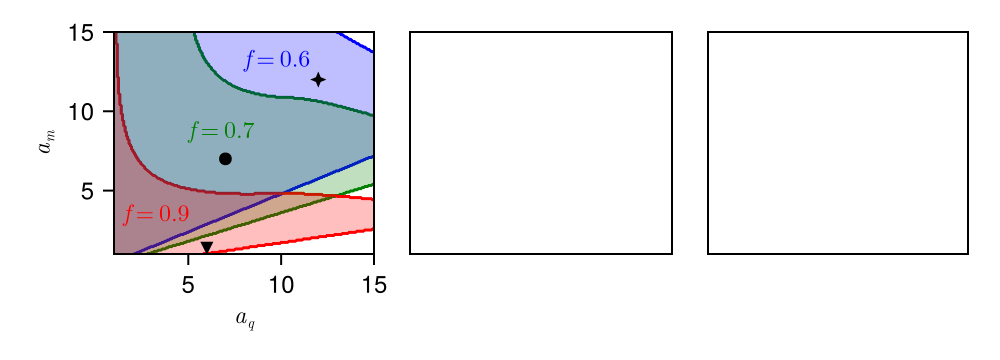

In [21]:
fig = Figure(size = (500,180), fontsize = 12.)

ax3 = Axis(fig[1,1],xlabel = L"a_q",ylabel = L"a_m",xgridvisible = false,ygridvisible = false)
ax1 = Axis(fig[1,2],xlabel = L"a_q",ylabel = L"a_m",xgridvisible = false,ygridvisible = false)
ax2 = Axis(fig[1,3],xlabel = L"a_q",ylabel = L"a_m",xgridvisible = false,ygridvisible = false)

lim = 1.5 # asymmetry ratio

# utility functions for plotting assigning asymmetric regions & boundaries 

function is_asymmetric(tup,l)
    if max(tup[1],tup[2]) > l*min(tup[1],tup[2])
        return 1.
    else
        return NaN
    end
end

function is_asymmetric_line(tup,l)
    if max(tup[1],tup[2]) > l*min(tup[1],tup[2])
        return 1.
    else 
        return 0.
    end
end

cf3 = contour!(ax3,aq_range,am_range,is_asymmetric_line.(z_as_05,lim),colormap = [:blue],colorrange = (0.,1.))
cf3 = contour!(ax3,aq_range,am_range,is_asymmetric_line.(z_as_075,lim),colormap = [:green],colorrange = (0.,1.))
cf3 = contour!(ax3,aq_range,am_range,is_asymmetric_line.(z_as_09,lim),colormap = [:red],colorrange = (0.,1.))

cf3 = heatmap!(ax3,aq_range,am_range,is_asymmetric.(z_as_05,lim),colormap = [:white,(:blue,0.25)],colorrange = (0.,1.))
cf3 = heatmap!(ax3,aq_range,am_range,is_asymmetric.(z_as_075,lim),colormap = [:white,(:green,0.25)],colorrange = (0.,1.))
cf3 = heatmap!(ax3,aq_range,am_range,is_asymmetric.(z_as_09,lim),colormap = [:white,(:red,0.25)],colorrange = (0.,1.))

ylims!(ax3,1,cap)
xlims!(ax3,1,cap)

text!(ax3,1.5,2.75,text = L"f = 0.9",color = :red)
text!(ax3,5.,8.,text = L"f = 0.7",color = :green)
text!(ax3,8,12.5,text = L"f = 0.6",color = :blue)

tp1 = (aq= 7, am=7)
tp2 = (aq= 6, am=1.5)
tp3 = (aq= 12, am=12)

scatter!(ax3,tp1[:aq],tp1[:am],marker = :circle,color  = :black)
scatter!(ax3,tp2[:aq],tp2[:am],marker = :dtriangle,color  = :black)
scatter!(ax3,tp3[:aq],tp3[:am],marker = :star4,color  = :black)

hidedecorations!(ax1)
hidedecorations!(ax2)

if save_figs
    save(plotsdir("AsyRegions.pdf"),fig)
end

fig


In [16]:
# tp1 # EvoSet_circle
# tp2 # EvoSet_triangle
# tp3 # EvoSet_star

p_set1 = [(f = f, hm = 2., am = tp1[:am], κm = 1., Δm = 1., hq = 2., aq = tp1[:aq], κq = 1., Δq = 1.) for f in [0.6,0.7,0.9]] #green
p_set2 = [(f = f, hm = 2., am = tp2[:am], κm = 1., Δm = 1., hq = 2., aq = tp2[:aq], κq = 1., Δq = 1.) for f in [0.6,0.7,0.9]] #triangle
p_set3 = [(f = f, hm = 2., am = tp3[:am], κm = 1., Δm = 1., hq = 2., aq = tp3[:aq], κq = 1., Δq = 1.) for f in [0.6,0.7,0.9]] #star

if run_evolution
    evo_pset1 = []

    N_gen = 10000

    for p_try in p_set1
        all_rp,all_rm = evolution(initial_spore,N_gen,Pm,q,p_try,PP,false);
        push!(evo_pset1,(all_rp,all_rm))
    end

    evo_pset2 = []

    for p_try in p_set2
        all_rp,all_rm = evolution(initial_spore,N_gen,Pm,q,p_try,PP,false);
        push!(evo_pset2,(all_rp,all_rm))
    end

    evo_pset3 = []

    for p_try in p_set3
        all_rp,all_rm = evolution(initial_spore,N_gen,Pm,q,p_try,PP,false);
        push!(evo_pset3,(all_rp,all_rm))
    end

    if save_data_outputs
        save("notebook_data/outputs/evo_pset1" * string(now()) * ".jld2",Dict("d"=>evo_pset1))
        save("notebook_data/outputs/evo_pset2" * string(now()) * ".jld2",Dict("d"=>evo_pset2))
        save("notebook_data/outputs/evo_pset3" * string(now()) * ".jld2",Dict("d"=>evo_pset3))
    end
else
    evo_pset1 = load("notebook_data/inputs/evo_pset1.jld2")["d"]
    evo_pset2 = load("notebook_data/inputs/evo_pset2.jld2")["d"]
    evo_pset3 = load("notebook_data/inputs/evo_pset3.jld2")["d"]
end

3-element Vector{Any}:
 (Any[1.0007539597379949, 1.00165307960468, 1.0002746436532388, 0.9993085126471415, 0.9968255738669556, 0.9989512956398957, 0.9985550431724216, 1.0003654503361155, 0.9986232742840064, 0.9990958141343687  …  6.915688906516708, 6.931641824705122, 6.951732166181333, 6.974940640713877, 6.995144953286668, 6.981234069669947, 7.013419444595333, 7.012241036042856, 6.98791167747204, 6.9814403942042365], Any[1.0005932548654495, 1.0023481436194948, 1.003618565207736, 1.006587538179481, 1.0067282907473891, 1.0057546360411713, 1.003950449735466, 1.003933572424422, 1.0043452282302539, 1.0070072104913974  …  14.506256511391832, 14.513869016602117, 14.503319920171498, 14.491142980184645, 14.487658326008637, 14.486665704953316, 14.487631700765615, 14.491171361537981, 14.496643614126567, 14.496952499136034])
 (Any[1.000612895210047, 1.0022314071812368, 1.003913632995458, 1.0020996409939253, 1.0031763984931192, 1.0011429185212857, 1.004433829178498, 1.0009002586337283, 1.0050655227

In [17]:
if save_data_outputs

    result_df1 = DataFrames.DataFrame()
    result_df2 = DataFrames.DataFrame()
    result_df3 = DataFrames.DataFrame()

    for (f,d) in zip(["0.6","0.7","0.9"],evo_pset1)
        if d[1][end] > d[2][end]
            result_df1[!,"EvoExperiment_aq=7_am=7_f=" * f * "_rp"] = d[1]
            result_df1[!,"EvoExperiment_aq=7_am=7_f=" * f * "_rm"] = d[2]
        else
            result_df1[!,"EvoExperiment_aq=7_am=7_f=" * f * "_rp"] = d[2]
            result_df1[!,"EvoExperiment_aq=7_am=7_f=" * f * "_rm"] = d[1]
        end
    end

    for (f,d) in zip(["0.6","0.7","0.9"],evo_pset2)
        if d[1][end] > d[2][end]
            result_df2[!,"EvoExperiment_aq=6_am=1.5_f=" * f * "_rp"] = d[1]
            result_df2[!,"EvoExperiment_aq=6_am=1.5_f=" * f * "_rm"] = d[2]
        else
            result_df2[!,"EvoExperiment_aq=6_am=1.5_f=" * f * "_rp"] = d[2]
            result_df2[!,"EvoExperiment_aq=6_am=1.5_f=" * f * "_rm"] = d[1]
        end
    end

    for (f,d) in zip(["0.6","0.7","0.9"],evo_pset3)
        if d[1][end] > d[2][end]
            result_df3[!,"EvoExperiment_aq=12_am=12_f=" * f * "_rp"] = d[1]
            result_df3[!,"EvoExperiment_aq=12_am=12_f=" * f * "_rm"] = d[2]
        else
            result_df3[!,"EvoExperiment_aq=12_am=12_f=" * f * "_rp"] = d[2]
            result_df3[!,"EvoExperiment_aq=12_am=12_f=" * f * "_rm"] = d[1]
        end
    end

    XLSX.writetable("notebook_data/outputs/evo_result_df_" * string(now()) * ".xlsx", "EvoSet_circle" => result_df1,"EvoSet_triangle" => result_df2,"EvoSet_star" => result_df3);
end

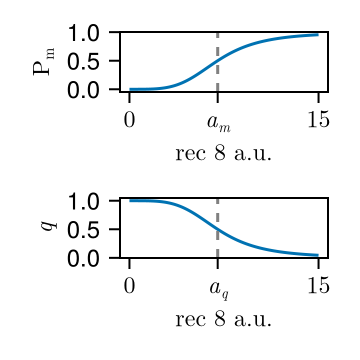

In [18]:
fig = CairoMakie.Figure(size = (180,180),fontsize = 12.)

ax_m = Axis(fig[1,1],ylabel = L"\text{P_m}",xgridvisible = false,ygridvisible = false)
ax_q = Axis(fig[2,1],ylabel = L"q",xgridvisible = false,ygridvisible = false)

CairoMakie.lines!(ax_m,0.:0.01:max_au_correspondence,[Pm(r,(f = 0.9, hm = 4., am = tp1[:am], κm = 1., Δm = 1., hq = 2., aq = tp1[:aq], κq = 1., Δq = 0.)) for r in 0.:0.01:max_au_correspondence],label = L"P_m")

CairoMakie.lines!(ax_q,0.:0.01:max_au_correspondence,[q(r,(f = 0.9, hm = 2., am = tp1[:am], κm = 1., Δm = 1., hq = 4., aq = tp1[:aq], κq = 1., Δq = 0.)) for r in 0.:0.01:max_au_correspondence],label = L"q")

vlines!(ax_m,tp1[:am],linestyle = :dash,color = :grey)
vlines!(ax_q,tp1[:aq],linestyle = :dash,color = :grey)

ax_m.xticks = ([0,tp1[:am],15],[L"0",L"a_m",L"15"])
ax_q.xticks = ([0,tp1[:aq],15],[L"0",L"a_q",L"15"])

ax_m.xlabel = L" \text{rec 8 a.u.}"
ax_q.xlabel = L" \text{rec 8 a.u.}"

if save_figs
    save(plotsdir("PQForm.pdf"),fig)
end

fig

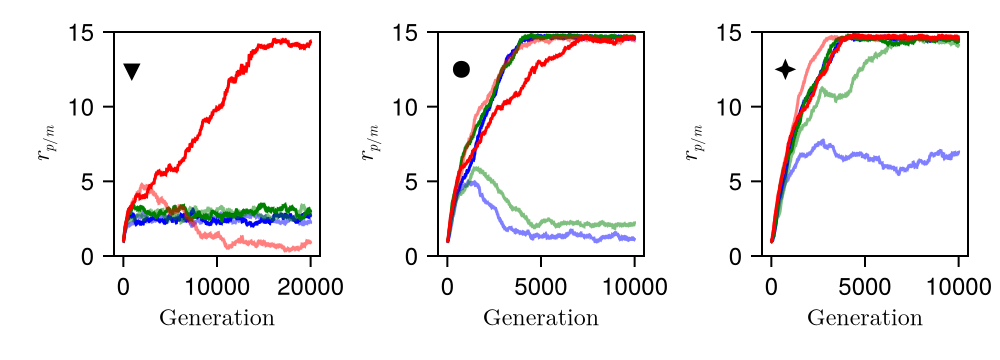

In [19]:
fig = Figure(size = (500,180), fontsize = 12.)

ax1 = Axis(fig[1,1], xlabel = L"\text{Generation}", ylabel = L"r_{p/m}",xgridvisible = false,ygridvisible = false)
ax2 = Axis(fig[1,2], xlabel = L"\text{Generation}", ylabel = L"r_{p/m}",xgridvisible = false,ygridvisible = false)
ax3 = Axis(fig[1,3], xlabel = L"\text{Generation}", ylabel = L"r_{p/m}",xgridvisible = false,ygridvisible = false)

colors = [:blue,:green,:red]

for (n,(all_rp,all_rm)) in enumerate(evo_pset2)

    if all_rp[end] < all_rm[end]
        lp = CairoMakie.lines!(ax1,Float64.(all_rp),color = (colors[n],0.5))
        lm = CairoMakie.lines!(ax1,Float64.(all_rm), color = colors[n])
    else
        lp = CairoMakie.lines!(ax1,Float64.(all_rp),color = colors[n])
        lm = CairoMakie.lines!(ax1,Float64.(all_rm), color = (colors[n],0.5))
    end

end

ax1.xticks = ([0,10000,20000],string.([0,10000,20000]))

scatter!(ax1,[900],[12.5],marker = :dtriangle,color  = :black,markersize = 12.)

for (n,(all_rp,all_rm)) in enumerate(evo_pset1)

    if all_rp[end] < all_rm[end]
        lp = CairoMakie.lines!(ax2,Float64.(all_rp),color = (colors[n],0.5))
        lm = CairoMakie.lines!(ax2,Float64.(all_rm), color = colors[n])
    else
        lp = CairoMakie.lines!(ax2,Float64.(all_rp),color = colors[n])
        lm = CairoMakie.lines!(ax2,Float64.(all_rm), color = (colors[n],0.5))
    end

end

scatter!(ax2,[750],[12.5],marker = :circle,color  = :black,markersize = 12.)

for (n,(all_rp,all_rm)) in enumerate(evo_pset3)

    if all_rp[end] < all_rm[end]
        lp = CairoMakie.lines!(ax3,Float64.(all_rp),color = (colors[n],0.5))
        lm = CairoMakie.lines!(ax3,Float64.(all_rm), color = colors[n])
    else
        lp = CairoMakie.lines!(ax3,Float64.(all_rp),color = colors[n])
        lm = CairoMakie.lines!(ax3,Float64.(all_rm), color = (colors[n],0.5))
    end

end

ylims!(ax1,0,15)
ylims!(ax2,0,15)
ylims!(ax3,0,15)

scatter!(ax3,[750],[12.5],marker = :star4,color  = :black,markersize = 12.)

if save_figs
    save(plotsdir("EvoSims.pdf"),fig)
end

fig

In [22]:
p_map = p_set2[3]  # use triangle parameters as example for bifurcation analysis

(f = 0.9, hm = 2.0, am = 1.5, κm = 1.0, Δm = 1.0, hq = 2.0, aq = 6, κq = 1.0, Δq = 1.0)

In [23]:
f_fitness = []

f_asym = []

f_sol = []

optf_2d = OptimizationFunction(reproductive_fitness_opt, Optimization.AutoForwardDiff())

optf_1d = OptimizationFunction(reproductive_fitness_opt_1d, Optimization.AutoForwardDiff())

u0_1d = [cap/2]
u0_2d = [cap/2,cap/2]

prob_1d = OptimizationProblem(optf_1d, u0_1d, p_map,lb = [0.], ub = [sqrt(cap^2 + cap^2)])

prob_2d = OptimizationProblem(optf_2d, u0_2d, p_map,lb = [0.,0.], ub = [cap,cap])

for f in 0.:0.005:1.

    p_new = (f=f,hm=p_map[2],am=p_map[3],κm=p_map[4],Δm=p_map[5],hq=p_map[6],aq=p_map[7],κq=p_map[8],Δq=p_map[9])

    prob_1d = remake(prob_1d, p = p_new)
    prob_2d = remake(prob_2d, p = p_new)

    sol_1d = solve(prob_1d,IPNewton())
    sol_2d = solve(prob_2d,IPNewton())

    fitness = [reproductive_fitness_sym(sol_1d[1],p_new),reproductive_fitness(sol_2d,p_new)]

    push!(f_asym,abs(sol_2d[2] - sol_2d[1]))

    push!(f_sol,sol_2d)

    push!(f_fitness, fitness)
end

f_asym = Float64.(f_asym);

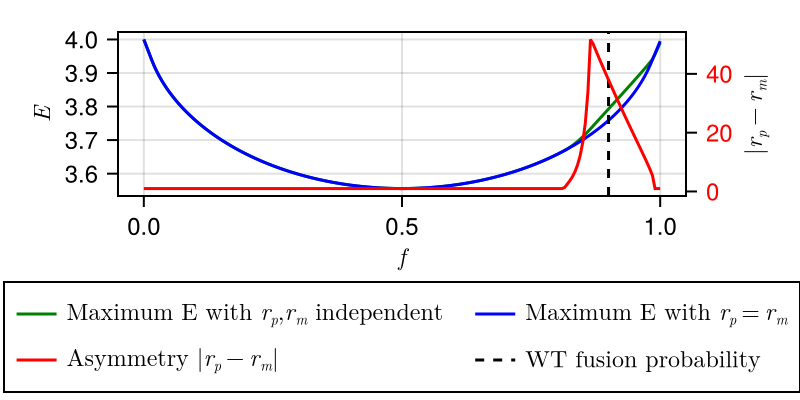

In [24]:
fig = Figure(size = (400,200), fontsize = 12.)

ax = Axis(fig[1:2,1:2], xlabel = L"f",ylabel = L"E")

ax2 = Axis(fig[1:2, 1:2], yticklabelcolor = :red, yaxisposition = :right,xgridvisible = false,ygridvisible = false,ylabel = L"|r_p-r_m|" )

hidespines!(ax2)
hidexdecorations!(ax2)
hidexdecorations!(ax2)

f1 = CairoMakie.lines!(ax,0.:0.005:1.,map(x->x[2],f_fitness),label = L"\text{Maximum E with } r_p,r_m \text{ independent}",color = :green)
f2 = CairoMakie.lines!(ax,0.:0.005:1.,map(x->x[1],f_fitness),label = L"\text{Maximum E with } r_p=r_m",color = :blue)

wtf = CairoMakie.vlines!(ax,p_map[1], color = :black,linestyle = :dash, label = L"\text{WT fusion probability}")

asy = CairoMakie.lines!(ax2,0.:0.005:1.,map(x->maximum(x)/minimum(x),f_sol),label = L"\text{Asymmetry } |r_p-r_m|",color = :red)

Legend(fig[3,1:2], [f1,f2,asy,wtf], [L"\text{Maximum E with } r_p,r_m \text{ independent}", L"\text{Maximum E with } r_p=r_m", L"\text{Asymmetry } |r_p-r_m|", L"\text{WT fusion probability}"],nbanks = 2)

if save_figs
    save(plotsdir("SymmetricVsAsymmetricFitness.pdf"),fig)
end

fig

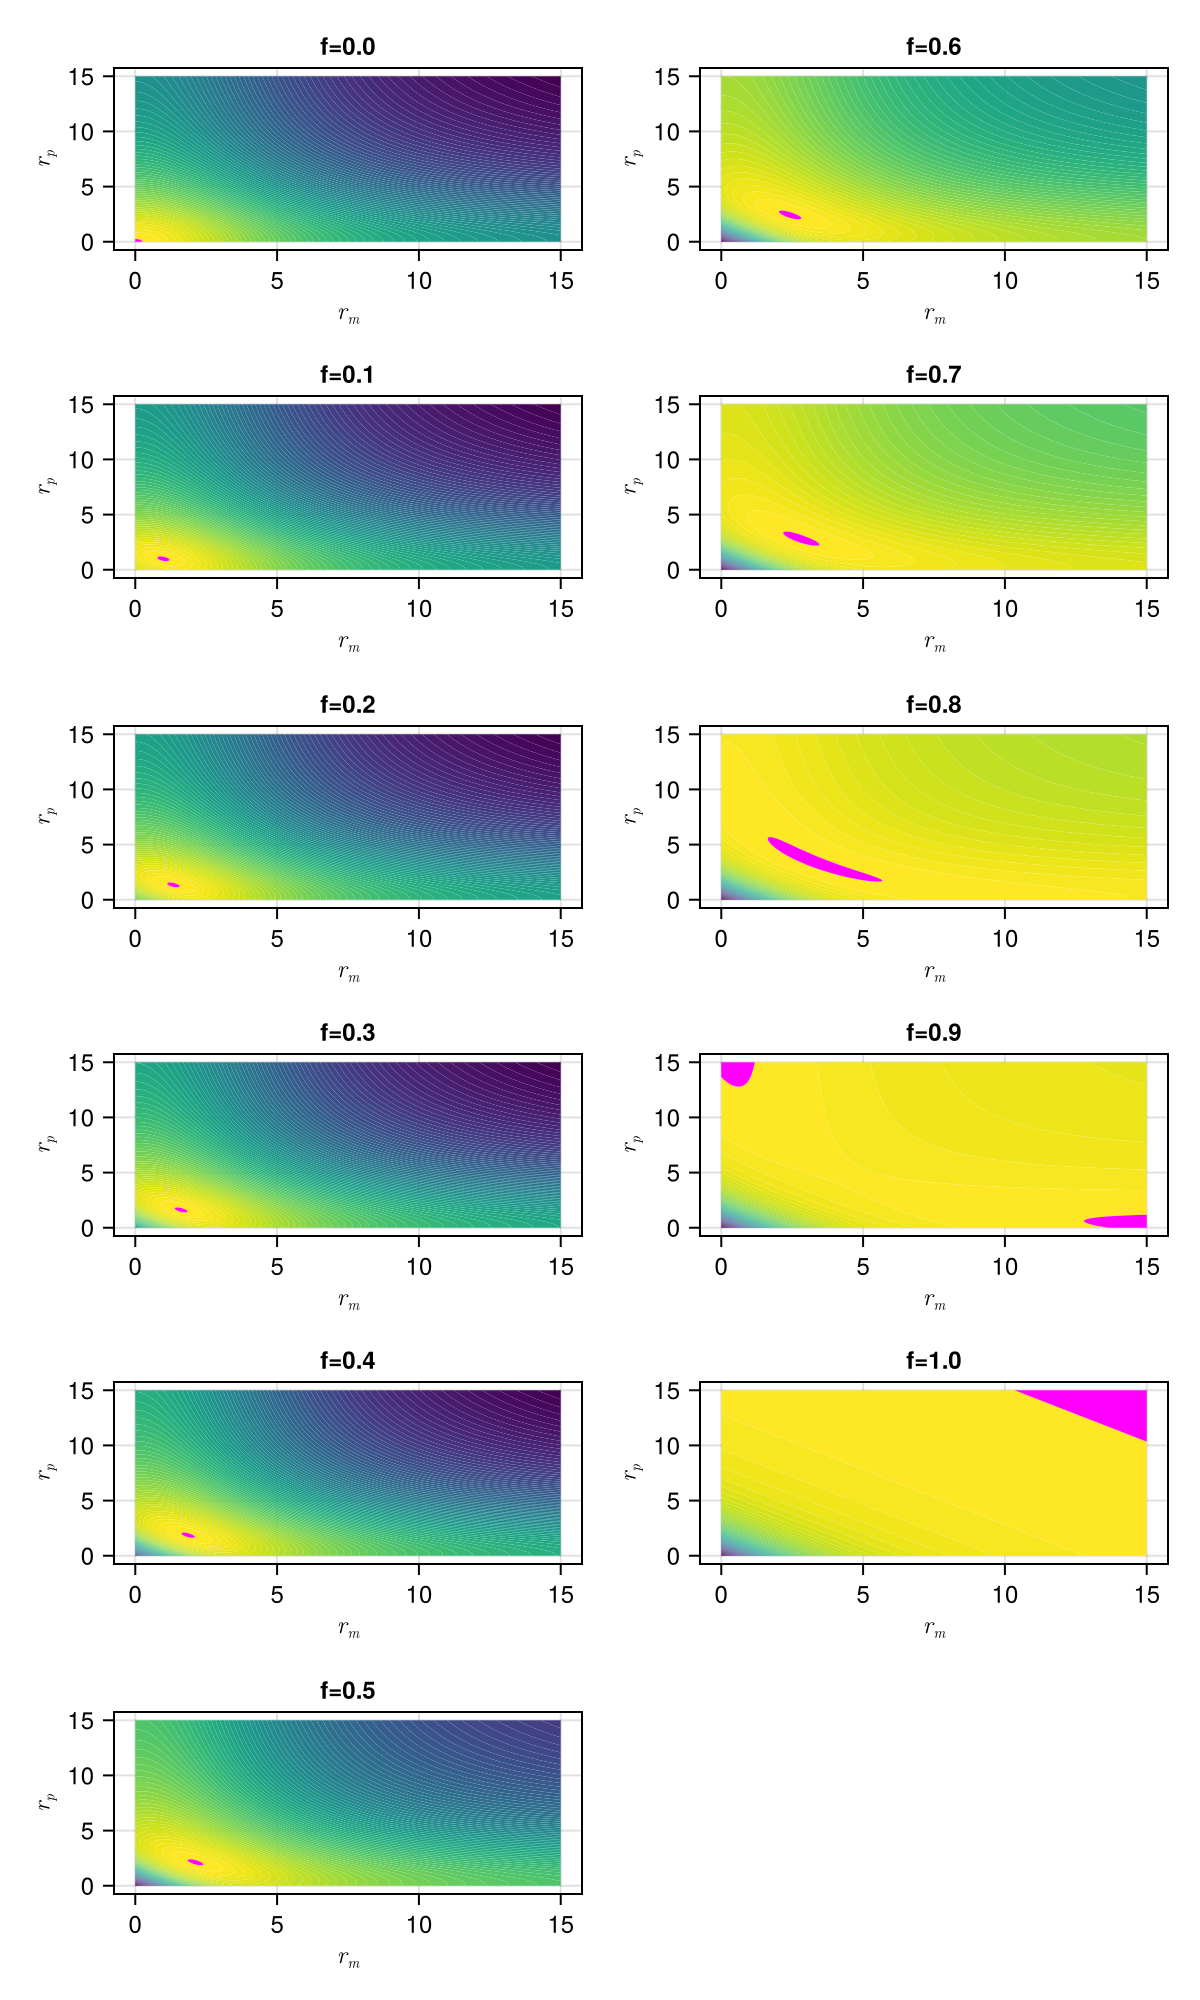

In [25]:
fig = Figure(size = (600,1000), fontsize = 12.)

plot_id = Tuple.(findall(x->x>0,ones(6,2)))

all_cf = []

for (n,f) in enumerate(0:0.1:1.)

    ax = Axis(fig[plot_id[n]...], xlabel = L"r_m",ylabel = L"r_p", title = "f=" * string(f))

    pf = (f=f,hm=p_map[2],am=p_map[3],κm=p_map[4],Δm=p_map[5],hq=p_map[6],aq=p_map[7],κq=p_map[8],Δq=p_map[9])

    rms = LinRange(0, cap, 1000)
    rps = LinRange(0, cap, 1000)

    zs = [reproductive_fitness(rm,rp,pf) for rm in rms, rp in rps];

    cf = contourf!(ax,rms,rps,zs,levels = LinRange(0.,0.999,100), mode = :relative, extendhigh = :magenta)

    push!(all_cf,cf)
end

if save_figs
    save(plotsdir("AsymmetricLandscapes_VaryF.pdf"),fig)
end

fig

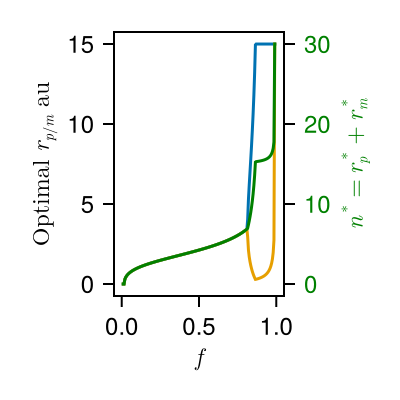

In [26]:
fig = Figure(size = (200,200), fontsize = 12.)

ax = Axis(fig[1,1], xlabel = L"f",ylabel = L"\text{Optimal } r_{p/m} \text{ au}",xgridvisible = false,ygridvisible = false)
ax1 = Axis(fig[1,1], xlabel = L"f",ylabel = L"n^{*} = r^{*}_p + r^{*}_m",yaxisposition = :right,yticklabelcolor = :green,ylabelcolor = :green,xgridvisible = false,ygridvisible = false)
hidespines!(ax1)
hidexdecorations!(ax1)

f1 = CairoMakie.lines!(ax,0.:0.005:1.,map(x->maximum(x),f_sol))
f2 = CairoMakie.lines!(ax,0.:0.005:1.,map(x->minimum(x),f_sol))# this looks time to fusion

f3 = CairoMakie.lines!(ax1,0.:0.005:1.,map(x->sum(x),f_sol),color= :green)# this looks time to fusion

# CairoMakie.hlines!(ax1,5,color = :black,linestyle = :dash)

if save_figs
    save(plotsdir("Bifurcation_in_f_with_nstar.pdf"),fig)
end

fig

In [27]:
PmData = expData["PmData"];
QData = expData["QData"];

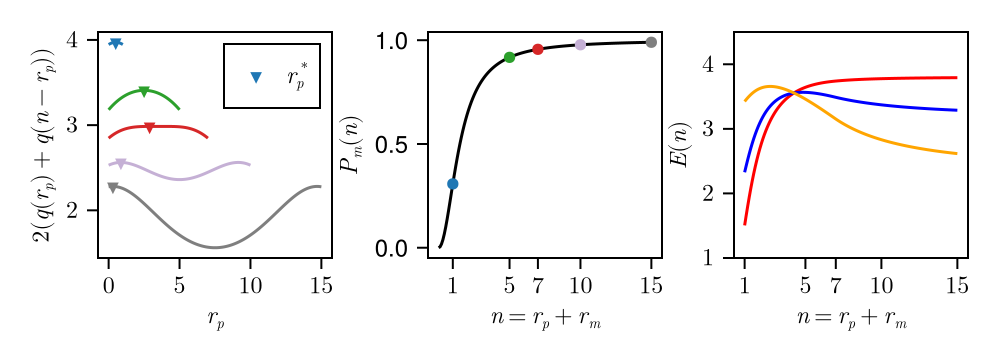

In [31]:
fig = Figure(size = (500,180), fontsize = 12.)

q_sym(r,n) = q(r,p_map) + q(n-r,p_map)

ax = Axis(fig[1,1], xlabel = L"r_p",ylabel = L"2(q(r_p) + q(n - r_p))",xgridvisible = false,ygridvisible = false)
ax1 = Axis(fig[1,2], xlabel = L"n = r_p + r_m",ylabel = L"P_m(n)",xgridvisible = false,ygridvisible = false)
ax2 = Axis(fig[1,3], xlabel = L"n = r_p + r_m",ylabel = L"E(n)",xgridvisible = false,ygridvisible = false)

n_sol = []
n_sol_max = []

choice_n = [1,5,7,10,15]

ms = 8.

for n in choice_n

    lines!(ax, 0:0.1:n,2*q_sym.(0:0.1:n,n),color = ColorSchemes.tab20[n])

    q_sym_opt(x,p) = -q_sym(x[1],n)

    q_sym_optf = OptimizationFunction(q_sym_opt, Optimization.AutoForwardDiff())
    
    u0 = [n/3]
    p0 = [0.]
    
    prob_1d = OptimizationProblem(q_sym_optf, u0, p0,lb = [0.],ub = [n])
    
    sol_1d = solve(prob_1d,BFGS())

    push!(n_sol,sol_1d)
    push!(n_sol_max,-q_sym_opt(sol_1d.u,p0))

    opt_q = min(sol_1d.u[1],n-sol_1d.u[1])

    if n == choice_n[1]
        scatter!(ax,[opt_q],[-2*q_sym_opt(opt_q,p0)],color = ColorSchemes.tab20[n],markersize = ms,marker = :dtriangle,label = L"r_p^*")
    else
        scatter!(ax,[opt_q],[-2*q_sym_opt(opt_q,p0)],color = ColorSchemes.tab20[n],markersize = ms,marker = :dtriangle)
    end
    
end 

CairoMakie.lines!(ax1,0:0.1:choice_n[end],[Pm(n,p_map) for n in 0:0.1:choice_n[end]],color = :black)
CairoMakie.scatter!(ax1,choice_n,[Pm(n,p_map) for n in choice_n],color = [ColorSchemes.tab20[n] for n in choice_n],markersize = ms)

n_sol = []
n_sol_max = []

tr = 1:0.1:cap

for n in tr 

    q_sym_opt(x,p) = -q_sym(x[1],n)

    q_sym_optf = OptimizationFunction(q_sym_opt, Optimization.AutoForwardDiff())
    
    u0 = [n/3]
    p0 = [0.]
    
    prob_1d = OptimizationProblem(q_sym_optf, u0, p0,lb = [0.],ub = [n])
    
    sol_1d = solve(prob_1d,BFGS())

    push!(n_sol,sol_1d)
    push!(n_sol_max,-q_sym_opt(sol_1d.u,p0))
end 

CairoMakie.lines!(ax2,tr,[4 * p_map[:f] * Pm(n,p_map) + 2*(1-p_map[:f]) *n_sol_max[i] for (i,n) in enumerate(tr)],color = :red,label = L"f = 0.9")

f = 0.6

CairoMakie.lines!(ax2,tr,[4 * f * Pm(n,p_map) + 2*(1-f) *n_sol_max[i] for (i,n) in enumerate(tr)],color = :blue,label = L"f = 0.6")

f = 0.2

CairoMakie.lines!(ax2,tr,[4 * f * Pm(n,p_map) + 2*(1-f) *n_sol_max[i] for (i,n) in enumerate(tr)],color = :orange,label = L"f = 0.2")

ax.xticks = ([0,5,10,15],[L"0",L"5",L"10",L"15"])
ax1.xticks = (choice_n,[L"1",L"5",L"7",L"10",L"15"])
ax2.xticks = (choice_n,[L"1",L"5",L"7",L"10",L"15"])

ylims!(ax2,1,4.5)

ax2.yticks = ([1,2,3,4],[L"1",L"2",L"3",L"4"])

ax.yticks = ([1,2,3,4],[L"1",L"2",L"3",L"4"])

axislegend(ax)

rowgap!(fig.layout,Relative(0.01))
colgap!(fig.layout,Relative(0.01))

if save_figs
    save(plotsdir("BifurcationExplanationPaper.pdf"),fig)
end

fig

In [32]:
if save_data_outputs

    E09 = [4 * p_map[:f] * Pm(n,p_map) + 2*(1-p_map[:f]) *n_sol_max[i] for (i,n) in enumerate(tr)]
    E06 = [4 * 0.6 * Pm(n,p_map) + 2*(1-0.6) *n_sol_max[i] for (i,n) in enumerate(tr)]
    E02 = [4 * 0.2 * Pm(n,p_map) + 2*(1-0.2) *n_sol_max[i] for (i,n) in enumerate(tr)];

    S5F_df = DataFrames.DataFrame()

    S5F_df[:,"f=0.9"] = E09
    S5F_df[:,"f=0.6"] = E06
    S5F_df[:,"f=0.2"] = E02

    XLSX.writetable("notebook_data/outputs/FitnessCurves_" * string(now()) * ".xlsx", S5F_df);
end

In [33]:
q_sym(r,n) = q(r,p_map) + q(n-r,p_map)

f_soln = []

tr = 1:0.1:cap

for n in tr

    q_sym_opt(x,p) = -q_sym(x[1],n)

    q_sym_optf = OptimizationFunction(q_sym_opt, Optimization.AutoForwardDiff())
    
    u0 = [n/10]
    p0 = [0.]
    
    prob_1d = OptimizationProblem(q_sym_optf, u0, p0,lb = [0.],ub = [n])
    
    sol_1d = solve(prob_1d,Fminbox();g_tol = 1e-12,allow_f_increases = true)

    push!(f_soln,[sol_1d[1],n-sol_1d[1]])

end

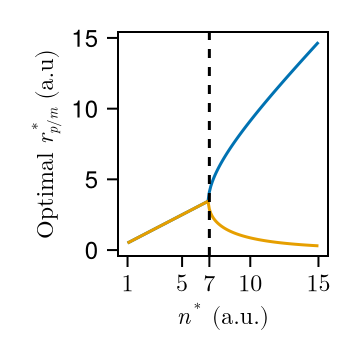

In [34]:
fig = Figure(size = (180,180), fontsize = 12.)

ax = Axis(fig[1,1], xlabel = L"n^{*} \text{ (a.u.)}",ylabel = L"\text{Optimal } r^{*}_{p/m} \text{ (a.u)}",xgridvisible = false,ygridvisible = false)

f1 = CairoMakie.lines!(ax, tr,map(x->maximum(x),f_soln))
f2 = CairoMakie.lines!(ax, tr,map(x->minimum(x),f_soln))

nc = tr[argmax(map(x->maximum(x) > 1.1*minimum(x),f_soln))]

vlines!(ax,nc, linestyle = :dash,color = :black)

ax.xticks = ([1,5,7,10,15],[L"1",L"5",L"7",L"10",L"15"])

if save_figs
    save(plotsdir("QBifurcation.pdf"),fig)
end

fig

In [35]:
f_soln = []

tr = 1:0.05:cap

all_nc = []

asym_ratio = 0.1

for (n,param) in enumerate(eachrow(posterior[1:10000,:]))

    if n % 5000 == 0
        print(n)
    end

    p_try = (f = 0.9, hm = param[2], am = param[3], κm = param[4], Δm = param[5], hq = param[6], aq = param[7], κq = param[8], Δq = param[9])

    q_sym(r,n) = 2*(1-p_try.f)*(q(r,p_try) + q(n-r,p_try))

    for n in tr

        q_sym_opt(x,p) = -q_sym(x[1],n)

        q_sym_optf = OptimizationFunction(q_sym_opt, Optimization.AutoForwardDiff())
        
        u0 = [n/3]
        p0 = [0.]
        
        prob_1d = OptimizationProblem(q_sym_optf, u0, p0,lb = [0.],ub = [n])
        
        sol_1d = solve(prob_1d,Fminbox();g_tol = 1e-12,allow_f_increases = true)

        if abs((sol_1d[1]/n) - 0.5) > asym_ratio
            push!(all_nc,n) 
            break
        elseif n == tr[end]
            push!(all_nc,NaN)
        else
            nothing
        end
    end
end

In [ ]:
all_nc = Float64.(all_nc)

k = kde(all_nc)

xgrid = range(minimum(all_nc); stop = maximum(all_nc), length = 1000)

ygrid = pdf.(Ref(k), xgrid)

threshold = first(hdr_thresholds([0.95], ygrid))

threshold

In [ ]:
fig = Figure(size = (180,200), fontsize = 12.)

ax = Axis(fig[1,1],xgridvisible = false,ygridvisible = false,xlabel = L"N_c \text{ (a.u)}", ylabel = L"\text{Frequency}")

CairoMakie.hist!(ax,all_nc, bins = 25, color = (:grey,0.5),normalization = :pdf)

ax.xticks = ([2,3,4,5,6,7], string.([2,3,4,5,6,7]))

vlines!(ax,kp+1,color = :red, linestyle = :dash)

if save_figs
    save(plotsdir("Nc_distributinN_ratio_" * string(asym_ratio) * "_" * string(kp) * "_CI.pdf"),fig)
end

fig

In [ ]:
mean(all_nc)

In [ ]:
ygrid[maximum(findall(xgrid .<= kp+1))]

In [ ]:
sum(all_nc .<= (kp+1)) / length(all_nc)

In [ ]:
wt_asym = all_nc .<= kp;